<a href="https://colab.research.google.com/github/Jeremy-su1/VLMs/blob/main/CLIP_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#@title Section 1. Install dependencies


%%capture
!pip install ftfy regex tqdm matplotlib opencv-python scipy scikit-image
!pip install git+https://github.com/openai/CLIP.git

import urllib.request
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import clip
from PIL import Image
from scipy.ndimage import filters
from torch import nn

%%capture : magic command, 셀 안에서 실행되는 모든 출력을 화면에 표시하지 않도록 한다.  
. ftfy: "fix text for you"의 약자로, 문자가 깨졌을 때 복구해주는 텍스트 전처리 도구  
. regex: 정규식 기능 제공  
. tqdm: progress bar library  
. matplotlib: visualization library  
. opencv-python: Image I/O, 전처리에 사용  
. scipy, scikit-image: 공학 연산과 이미지 처리용 util


In [5]:
#@title Section 2. Helper functions

# 범위가 정해져 있지 않은 배열을 시각화하기 전 [0,1]로 정규화를 시켜줌
def normalize(x: np.ndarray) -> np.ndarray:
    # Normalize to [0, 1].
    x = x - x.min()
    if x.max() > 0:
        x = x / x.max()
    return x

# Modified from: https://github.com/salesforce/ALBEF/blob/main/visualization.ipynb
def getAttMap(img, attn_map, blur=True):
    # 시각적 가독성 향상을 위해 attention map에 가우시안 블러 적용
    if blur:
        attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
        # 이미지의 약 2% 크기를 표준 편차로 filter 적용
    attn_map = normalize(attn_map)
    # [0,1] 범위로 정규화
    cmap = plt.get_cmap('jet')
    # jet 컬러맵을 가져와서 attention 값에 색 입히기
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    # RGBA -> RGB로
    attn_map = 1*(1-attn_map**0.7).reshape(attn_map.shape + (1,))*img + \
            (attn_map**0.7).reshape(attn_map.shape+(1,)) * attn_map_c
    # alpha blending: 원본 이미지와 컬러맵을 0.7 승으로 강조해 합성
    return attn_map

def viz_attn(img, attn_map, blur=True):
    # 1*2 subplot 생성 (원본 vs. overlay)
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img) #원본
    axes[1].imshow(getAttMap(img, attn_map, blur)) #attention overlay
    for ax in axes:
        ax.axis("off")
    plt.show()

def load_image(img_path, resize=None):
    # PIL로 이미지 열고 RGB로 통일
    image = Image.open(img_path).convert("RGB")
    # resize 값이 주어지면 정사각형으로 크기 조정
    if resize is not None:
        image = image.resize((resize, resize))
    # pixel [0,255] -> [0,1] float32 numpy array로 변환
    return np.asarray(image).astype(np.float32) / 255.

```
getAttMap
```
- 2D Attention 맵에 시각 효과(블러, 컬러맵, 투명도)를 입혀 원본 이미지 위에 overlay.
- blur=True 가우시안 블러로 매끄러운 하이라이트 생성
- Jet 컬러맵을 적용한 후 $(1-\alpha)*원본 + \alpha*컬러맵$ 방식으로 반투명 합성  

```
viz_attn
```
- getAttMap 함수로 만든 overlay와 원본 이미지를 나란히 그려주는 function
- 시각 비교를 쉽게 하기 위한 시각화 유틸



In [6]:
#@title Section 3. GradCAM: Gradient-weighted Class Activation Mapping

#@markdown Our gradCAM implementation registers a forward hook
#@markdown on the model at the specified layer. This allows us
#@markdown to save the intermediate activations and gradients
#@markdown at that layer.

#@markdown To visualize which parts of the image activate for
#@markdown a given caption, we use the caption as the target
#@markdown label and backprop through the network using the
#@markdown image as the input.
#@markdown In the case of CLIP models with resnet encoders,
#@markdown we save the activation and gradients at the
#@markdown layer before the attention pool, i.e., layer4.

# Hook 클래스: 지정한 layer의 forward 출력을 유지하고, backpropagation시 gradient도 보관함
class Hook:
    """Attaches to a module and records its activations and gradients."""

    def __init__(self, module: nn.Module):
        # forward hook 등록: forward output일때 save_grad 호출
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)

    def save_grad(self, module, input, output):
        # forward output을 저장
        self.data = output
        # 나중에 역전파 gradient를 보관하도록 requires_grad 설정
        output.requires_grad_(True)
        output.retain_grad()

    def __enter__(self):
        # with 문 진입 시 Hook 객체 반환
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        # with 문 종료 시 hook 해제
        self.hook.remove()

    @property
    def activation(self) -> torch.Tensor:
        # 저장된 forward 활성화 맵 반환
        return self.data

    @property
    def gradient(self) -> torch.Tensor:
        # 저장된 gradient 반환
        return self.data.grad


# Reference: https://arxiv.org/abs/1610.02391
def gradCAM(
    model: nn.Module, # CLIP visual encoder
    input: torch.Tensor, # 전처리된 이미지 tensor(1,C,H,W)
    target: torch.Tensor, # 텍스트 인코더로부터 얻은 임베딩
    layer: nn.Module # Hook 처리 될 layer
) -> torch.Tensor:
    # Zero out any gradients at the input.
    if input.grad is not None:
        input.grad.data.zero_()

    # Disable gradient settings.
    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)

    # Attach a hook to the model at the desired layer.
    assert isinstance(layer, nn.Module)
    with Hook(layer) as hook:
        # Do a forward and backward pass.
        output = model(input)
        output.backward(target)

        grad = hook.gradient.float()
        act = hook.activation.float()

        # Global average pool gradient across spatial dimension
        # to obtain importance weights.
        alpha = grad.mean(dim=(2, 3), keepdim=True)
        # Weighted combination of activation maps over channel
        # dimension.
        gradcam = torch.sum(act * alpha, dim=1, keepdim=True)
        # We only want neurons with positive influence so we
        # clamp any negative ones.
        gradcam = torch.clamp(gradcam, min=0)

    # Resize gradcam to input resolution.
    gradcam = F.interpolate(
        gradcam,
        input.shape[2:],
        mode='bicubic',
        align_corners=False)

    # Restore gradient settings.
    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])

    return gradcam

<ipython-input-5-22917b6c3f88>:15: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))


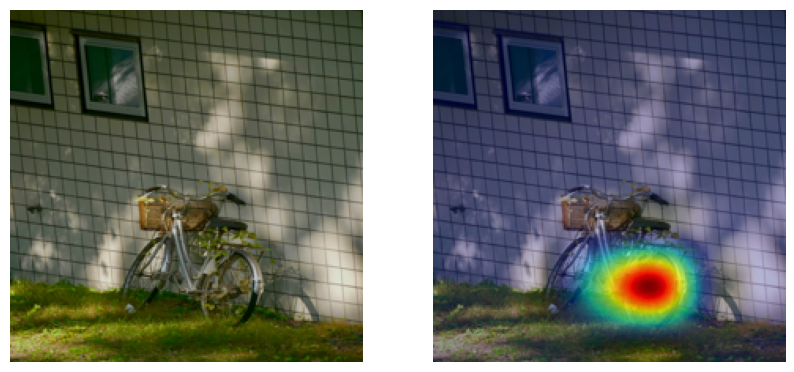

In [20]:
#@title Section 4. Run

#@markdown #### Image & Caption settings
#image_url = 'https://images2.minutemediacdn.com/image/upload/c_crop,h_706,w_1256,x_0,y_64/f_auto,q_auto,w_1100/v1554995050/shape/mentalfloss/516438-istock-637689912.jpg' #@param {type:"string"}
#image_url = 'https://unsplash.com/photos/gKXKBY-C-Dk/download?ixid=M3wxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNzQ1NDE0MTcwfA&force=true' #@param {type:"string"}
image_url = 'https://unsplash.com/photos/a4K0LCe4Rps/download?ixid=M3wxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNzQ1NDE1MjkwfA&force=true' #@param {type:"string"}
image_caption = 'the bike' #@param {type:"string"}
#@markdown ---

# ==== CLIP 모델 종류와 attention hook을 달 layer를 선택 ====
#@markdown #### CLIP model settings
clip_model = "RN101" #@param ["RN50", "RN101", "RN50x4", "RN50x16"]
saliency_layer = "layer4" #@param ["layer4", "layer3", "layer2", "layer1"]
# GradCAM Hook을 걸어 중간 activation과 gradient를 뽑아낼 layer

# ==== 시각화 옵션 ====
#@markdown ---
#@markdown #### Visualization settings
blur = True #@param {type:"boolean"}

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)

# Download the image from the web.
image_path = 'image.png'
urllib.request.urlretrieve(image_url, image_path)

image_input = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
image_np = load_image(image_path, model.visual.input_resolution)
text_input = clip.tokenize([image_caption]).to(device)

attn_map = gradCAM(
    model.visual,
    image_input,
    model.encode_text(text_input).float(),
    getattr(model.visual, saliency_layer)
)
attn_map = attn_map.squeeze().detach().cpu().numpy()

viz_attn(image_np, attn_map, blur)